# Movie Search Blog
## Part 0 - Prepare IMDB Data for Neptune
Obtain IMDB data. Read https://developer.imdb.com/non-commercial-datasets/ and confirm your usage conforms to IMDB license. Download the following files and place in the ```source``` subfolder.

- name.basics.tsv
- title.basics.tsv
- title.ratings.tsv
- title.principals.tsv

Run the cells below to produce CSV files to load to Neptune. These appear in the ```prep``` folder. 

- movies.csv
- genres.csv
- artists.csv
- m2a.csv
- m2g.csv

When done, copy these CSV files to an S3 bucket in the same region in which you will be running Neptune and OpenSearch Service. Place in a folder of the bucket called ```source```.

- s3://<mybucket>/source/movies.csv
- s3://<mybucket>/source/genres.csv
- s3://<mybucket>/source/artists.csv
- s3://<mybucket>/source/m2a.csv
- s3://<mybucket>/source/m2g.csv

You will need these in the next two notebooks. Here is the graph model we will be using. The data above is for ```movie```, ```Artist```, and ```Genre``` nodes. We will not populate ```Person``` or ```Place``` nodes.
    
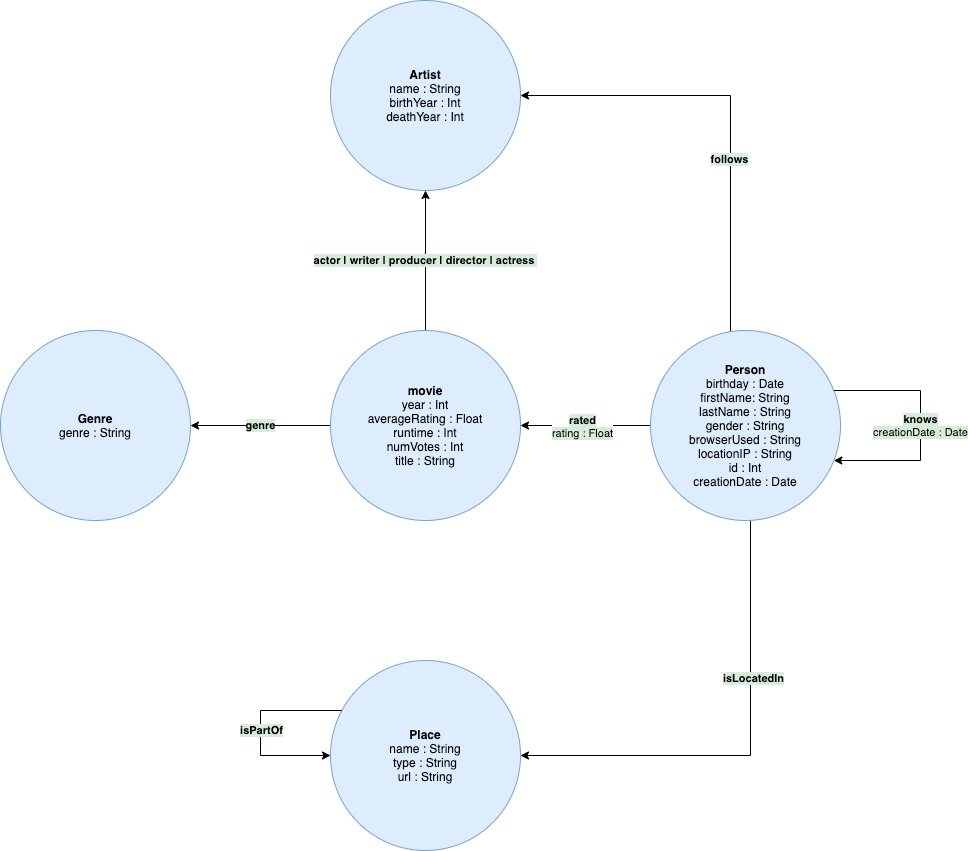
    
    
## Setup

In [ ]:
# CSV reader/writer helpers
# Scales better with large files. Stream in/out, no big frames in memory

import csv

def csv_writer_open(fname, headers):
    ff = []
    ff.append(open(fname, "w"))
    ff.append(csv.writer(ff[0]))
    ff[1].writerow(headers)
    return ff

def csv_reader_open(fname, delim='\t'):
    ff = []
    ff.append(open(fname, "r"))
    ff.append(csv.reader(ff[0],delimiter=delim ))
    for header in ff[1]:
        ff.append(header)
        break
    return ff

def csv_close(ff):
    ff[0].close()

def make_edge(label, n1, n2):
    return f"{label}-{n1}-{n2}"

def optional_val(row, n):
    return row[n] if not(row[n]=='\\N') else ""

def get_next(ff, stop_id):
    for row in ff[1]:
        if row[0] >= stop_id:
            return row
    return None

In [ ]:
!gunzip source/*.gz

In [ ]:
!mkdir -p prep

## Artists

In [ ]:
nep_artists=csv_writer_open('prep/artists.csv', ["~id", "~label", "name:string", "birthYear:int", "deathYear:int"])
artists=csv_reader_open('source/name.basics.tsv')
for row in artists[1]:
    id=row[0]
    name=row[1]
    by=optional_val(row, 2)
    dy=optional_val(row, 3)
    nep_artists[1].writerow([id, "Artist", name, by, dy])

csv_close(artists)
csv_close(nep_artists)

## Movies, Genres, Ratings

In [39]:
distinct_genres={}

nep_movies=csv_writer_open('prep/movies.csv', ["~id", "~label", "title:string", "year:int", "runtime:int", "averageRating:float", "numVotes:int"])
nep_m2g=csv_writer_open('prep/m2g.csv', ["~id","~from","~to","~label"])
nep_genres=csv_writer_open('prep/genres.csv', ["~id","~label", "genre:string"])

ratings=csv_reader_open('source/title.ratings.tsv')
movies=csv_reader_open('source/title.basics.tsv')

# we will need this later; about 700K small strings 
mid_cache = {}

next_rating=None

for row in movies[1]:
    if len(row) < 9: # a few weird entries
        continue
    id=row[0]
    mtype=row[1]
    if not(mtype=="movie"):
        continue
    name=row[2]
    y=optional_val(row, 5)
    rt=optional_val(row, 7)
    gs=optional_val(row, 8).split(",")
    rtg=""
    nv=""
    
    if next_rating is None or next_rating[0] < id:
        next_rating = get_next(ratings, id)
        assert(next_rating is None or next_rating[0] >= id)

    if not(next_rating is None) and next_rating[0] == id:
            rtg=optional_val(next_rating, 1)
            nv=optional_val(next_rating, 2)

    nep_movies[1].writerow([id, "movie", name, y, rt, rtg, nv])
    mid_cache[id]=id
    for g in gs:
        if len(g) > 0:
            distinct_genres[g]=g
            nep_m2g[1].writerow([make_edge("genre", id, g), id, g, "genre"])
    
for g in distinct_genres:
    nep_genres[1].writerow([g, "Genre", g])

csv_close(movies)
csv_close(ratings)
csv_close(nep_movies)
csv_close(nep_genres)
csv_close(nep_m2g)

## Cast/Filmography

In [40]:
m2a=csv_reader_open('source/title.principals.tsv')
nep_m2a=csv_writer_open('prep/m2a.csv', ["~id","~from","~to","~label"])

for row in m2a[1]:
    mid=row[0]
    aid=row[2]
    role=row[3]
    
    # GNN embedding model needs clean edges; 
    # not all movies referenced in this file are movie vertices
    # filter to those movies that are to produce clean edges
    if mid in mid_cache:    
        if role in ['actor', 'actress', 'director', 'producer', 'writer']:
            nep_m2a[1].writerow([make_edge(role, mid, aid), mid, aid, role])
        
csv_close(m2a)
csv_close(nep_m2a)
